# Blue Waters Petascale Semester Curriculum v1.0
## Unit 7: CUDA
## Lesson 9: Heat Diffusion in 1-2 D
### File: Heat_Equation_In_Cuda_1_and2D.ipynb
#### Developed by David A. Joiner for the Shodor Education Foundation, Inc.
*Except where otherwise noted, this work by The Shodor Education Foundation, Inc. is licensed under CC BY-SA 4.0. To view a copy of this license, visit https://creativecommons.org/licenses/by-sa/4.0*

*Browse and search the full curriculum at http://shodor.org/petascale/materials/semester-curriculum*
 
*We welcome your improvements! You can submit your proposed changes to this material and the rest of the curriculum in our GitHub repository at https://github.com/shodor-education/petascale-semester-curriculum*

*We want to hear from you! Please let us know your experiences using this material by sending email to petascale@shodor.org*

#Student Instructions

Read and review the heat1.cu code. 

1. In the main routine, what is the effect of changing the variable "method" in the code? What are the two values to which it can be set?

2. Note the use of allocated memory for both the device and host, as well as copy statements before and after the main device iterative loop. Why are two copies of the arrays required when parallelizing code using CUDA?

3. CUDA devices have limitations on both the number of threads per block, the total number of blocks, the total number of threads requested, and other resources. How does the behaviour of your code change if you exceed these resources? What warnings are provided? [Hint, set threads per block to 20000, well above typical allowed threads per block. How does this break the code? Does the broken code run faster or slower than the none broken code? Is it obvious that it is broken when you first run it?]

4. Using the heat2_starter.cu, provide a kernel that will mimic the behaviour of the CPU based kernel provided. You can use heat1.cu as a model. Please use the provided memory structure of a flattened 1-D array for your temperature grid, where the rapidly changing index is column and [i*ncol+j] corresponds to the ith row and jth column. Use a 2-D breakdown of your blocks and threads per block, so that changing in the x direction in thread-block space corresponds to changing the column, and changing in the y direction in thread-block space corresponds to changing the row. 

5. Run your 2D code for different choices of grid dimensions and block dimensions, as well as different problem sizes, and discuss the speedup that results.

##Teacher instructions

Solved code is provided.

When working with the students to parallelize their code, it can be useful to discuss a few key issues.

* Asking for more resources, either in total or in certain manners (e.g. too many threads per block) will not only not produce an error, it will likely run with great speed (though erroneous results) fooling the students into thinking they have sped up their problem. Focus on the need for always checking the accuracy of results and checking for errors, especially when debugging CUDA code.

* Depending on machine, you may need specific compile options. Students may investigate setting the compute level and archiecture at compile time to see if it speeds up, slows down, or breaks their code.

* Have the students investigate pairing up the rapidly changing variable in the flattened array with either the x or y dimension in thread space for the 2D problem, to see if there is a performance difference.

In [ ]:
%%writefile heat1.cu
/* Blue Waters Petascale Semester Curriculum v1.0
 * Unit 7: CUDA
 * Lesson 9: Heat Diffusion in 1-2 D
 * File: heat1.cu
 * Developed by David A. Joiner for the Shodor Education Foundation, Inc.
 *
 * Copyright (c) 2020 The Shodor Education Foundation, Inc.
 *
 * Browse and search the full curriculum at
 * <http://shodor.org/petascale/materials/semester-curriculum>.
 *
 * We welcome your improvements! You can submit your proposed changes to this
 * material and the rest of the curriculum in our GitHub repository at
 * <https://github.com/shodor-education/petascale-semester-curriculum>.
 *
 * We want to hear from you! Please let us know your experiences using this
 * material by sending email to petascale@shodor.org
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU Affero General Public License as published
 * by the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU Affero General Public License for more details.
 *
 * You should have received a copy of the GNU Affero General Public License
 * along with this program.  If not, see <https://www.gnu.org/licenses/>.
 */

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>

#define METHOD_DEVICE 0
#define METHOD_HOST 1

#define MIN(a,b) (((a)<(b))?(a):(b))
#define MAX(a,b) (((a)>(b))?(a):(b))

__global__ void compute_average_device(int n, double * average, double * T) {
    int i = 1+threadIdx.x+blockDim.x*blockIdx.x;

    while(i<n-1) {
        average[i] = (1.0/3.0)*(T[i-1]+T[i]+T[i+1]);

        i += blockDim.x*gridDim.x;
    }
}

void compute_average_host(int n, double * average, double * T) {
    int i;
    for(i=1;i<n-1;i++) {
        average[i] = (1.0/3.0)*(T[i-1]+T[i]+T[i+1]);
    }
}

int main(int argc, char ** argv) {
    int n = 256*256;
    double * T_host = (double *)malloc(sizeof(double)*n);
    double * average_host = (double *)malloc(sizeof(double)*n);
    double * T_device;
    double * average_device;
    double t_left = 0.0;
    double t_right = 100.0;
    double t_max = 200.0;
    int itmax = 100;
    int i,iter;
    int method = METHOD_DEVICE;
    int n_total_threads = 1024;
    int n_threads_per_block = 32;
    int n_blocks = n_total_threads/n_threads_per_block;
    cudaEvent_t start, stop;
    cudaEvent_t write_start, write_stop;
    cudaEvent_t read_start, read_stop;
    float milliseconds = 0;
    float write_ms = 0;
    float read_ms = 0;

    //n_blocks = 128;
    //n_threads_per_block = 64;

    cudaMalloc(&T_device,n*sizeof(double));   //allocate device
    cudaMalloc(&average_device,n*sizeof(double));  

    // initialize temperature
    T_host[0] = t_left;
    T_host[n-1] = t_right;
    for(i=1;i<n-1;i++) {
        T_host[i] = t_max*rand()/RAND_MAX;
    }
    for(i=0;i<n;i++) {
        average_host[i]=T_host[i];
    }

    // iterative loop, each turn replace interior values with the average of
    // itself and its neighbors

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventCreate(&write_start);
    cudaEventCreate(&write_stop);
    cudaEventCreate(&read_start);
    cudaEventCreate(&read_stop);



    cudaEventRecord(start);
    if(method==METHOD_HOST) {
        for(iter=0;iter<itmax;iter+=2) {
            compute_average_host(n,average_host,T_host);
            compute_average_host(n,T_host,average_host);
        }
    } else {  // method == METHOD_DEVICE
        cudaEventRecord(write_start);
        cudaMemcpy(T_device,T_host,n*sizeof(double),cudaMemcpyHostToDevice);
        cudaMemcpy(average_device,average_host,n*sizeof(double),cudaMemcpyHostToDevice);
        cudaEventRecord(write_stop);
        cudaEventSynchronize(write_stop);
        cudaEventElapsedTime(&write_ms, write_start, write_stop);
        for(iter=0;iter<itmax;iter+=2) {
            compute_average_device<<<n_blocks,n_threads_per_block>>>(n,average_device,T_device);
            compute_average_device<<<n_blocks,n_threads_per_block>>>(n,T_device,average_device);
        }
        cudaEventRecord(read_start);
        cudaMemcpy(T_host,T_device,n*sizeof(double),cudaMemcpyDeviceToHost);
        cudaEventRecord(read_stop);
        cudaEventSynchronize(read_stop);
        cudaEventElapsedTime(&read_ms, read_start, read_stop);
    }

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);

    // print output
    for(i=0;i<n;i++) {
        printf("%lf\n",T_host[i]);
    }
    if(method == METHOD_DEVICE) {
        fprintf(stderr,"Elapsed time sending memory to device (ms) %f\n",write_ms);
        fprintf(stderr,"Elapsed time reading memory from device (ms) %f\n",read_ms);
    }
    fprintf(stderr,"Elapsed time in loop (ms) %f\n",milliseconds);

    free(T_host);    
    free(average_host);
    cudaFree(T_device);
    cudaFree(average_device);
}

Overwriting heat1.cu


In [ ]:
!nvcc  -o heat1 heat1.cu

In [ ]:
!./heat1 > out1

Elapsed time sending memory to device (ms) 0.307232
Elapsed time reading memory from device (ms) 0.132800
Elapsed time in loop (ms) 4.910784


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

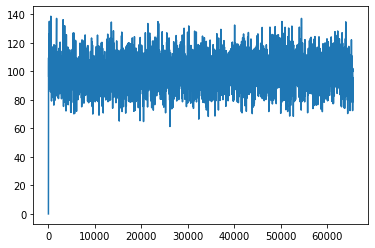

In [ ]:
data = pd.read_csv("./out1",header=None)
T =  data[0]
plt.plot(T)
plt.show()

In [ ]:
%%writefile heat2_starter.cu
/* Blue Waters Petascale Semester Curriculum v1.0
 * Unit 7: CUDA
 * Lesson 9: Heat Diffusion in 1-2 D
 * File: heat2_starter.cu
 * Developed by David A. Joiner for the Shodor Education Foundation, Inc.
 *
 * Copyright (c) 2020 The Shodor Education Foundation, Inc.
 *
 * Browse and search the full curriculum at
 * <http://shodor.org/petascale/materials/semester-curriculum>.
 *
 * We welcome your improvements! You can submit your proposed changes to this
 * material and the rest of the curriculum in our GitHub repository at
 * <https://github.com/shodor-education/petascale-semester-curriculum>.
 *
 * We want to hear from you! Please let us know your experiences using this
 * material by sending email to petascale@shodor.org
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU Affero General Public License as published
 * by the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU Affero General Public License for more details.
 *
 * You should have received a copy of the GNU Affero General Public License
 * along with this program.  If not, see <https://www.gnu.org/licenses/>.
 */

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>

#define METHOD_DEVICE 0
#define METHOD_HOST 1

#define MIN(a,b) (((a)<(b))?(a):(b))
#define MAX(a,b) (((a)>(b))?(a):(b))

__global__ void compute_average_device(int nrows, int ncols, double * average, double * T) {
    // WRITE KERNEL CODE HERE
}



void compute_average_host(int nrows, int ncols, double * average, double * T) {
    int i,j;
    for(i=1;i<nrows-1;i++) {
        for(j=1;j<ncols-1;j++) {
            average[i*ncols+j] = (1.0/5.0)*(T[(i-1)*ncols+j]+
                                            T[i*ncols+j]+
                                            T[(i+1)*ncols+j]+
                                            T[i*ncols+j+1]+
                                            T[i*ncols+j-1]
                                           );
        }
    }
}





int main(int argc, char ** argv) {
    int nrows = 256;
    int ncols = 256;
    double * T_host = (double *)malloc(sizeof(double)*nrows*ncols);
    double * average_host = (double *)malloc(sizeof(double)*nrows*ncols);
    double * T_device;
    double * average_device;
    double t_left = 0.0;
    double t_right = 100.0;
    double t_top = 100.0;
    double t_bottom = 0.0;
    double t_max = 200.0;
    int itmax = 100;
    int i,j,iter;
    int method = METHOD_DEVICE;
    int n_total_threads_x = nrows;
    int n_total_threads_y = ncols;
    int n_threads_per_block_x = 16;
    int n_threads_per_block_y = 16;
    int n_blocks_x = MAX(1,n_total_threads_x/n_threads_per_block_x);
    int n_blocks_y = MAX(1,n_total_threads_y/n_threads_per_block_y);
    cudaEvent_t start, stop;
    cudaEvent_t write_start, write_stop;
    cudaEvent_t read_start, read_stop;
    float milliseconds = 0;
    float write_ms = 0;
    float read_ms = 0;



    cudaMalloc(&T_device,nrows*ncols*sizeof(double));   //allocate device
    cudaMalloc(&average_device,nrows*ncols*sizeof(double));  

    // initialize temperature, rapidly changing variable is column
    //  T[i*ncols+j] maps to row-column T[i][j]
    for(j=0;j<ncols;j++) {
        T_host[0*ncols+j] = t_top;
        T_host[(nrows-1)*ncols+j] = t_bottom;
    }
    for(i=0;i<nrows;i++) {
        T_host[i*ncols+0] = t_left;
        T_host[i*ncols+ncols-1] = t_right;
    }
    for(i=1;i<nrows-1;i++) {
        for(j=1;j<ncols-1;j++) {
            T_host[i*ncols+j] = t_max*rand()/RAND_MAX;            
        }
    }
    for(i=0;i<nrows*ncols;i++) {
        average_host[i]=T_host[i];
    }

    // iterative loop, each turn replace interior values with the average of
    // itself and its neighbors

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventCreate(&write_start);
    cudaEventCreate(&write_stop);
    cudaEventCreate(&read_start);
    cudaEventCreate(&read_stop);

    dim3 grid(n_blocks_x,n_blocks_y);
    dim3 block(n_threads_per_block_x,n_threads_per_block_y);
    //dim3 grid(16,16);
    //dim3 block(16,16);


    cudaEventRecord(start);
    if(method==METHOD_HOST) {
        for(iter=0;iter<itmax;iter+=2) {
            compute_average_host(nrows,ncols,average_host,T_host);
            compute_average_host(nrows,ncols,T_host,average_host);
        }
    } else {  // method == METHOD_DEVICE
        cudaEventRecord(write_start);
        cudaMemcpy(T_device,T_host,nrows*ncols*sizeof(double),cudaMemcpyHostToDevice);
        cudaMemcpy(average_device,average_host,nrows*ncols*sizeof(double),cudaMemcpyHostToDevice);
        cudaEventRecord(write_stop);
        cudaEventSynchronize(write_stop);
        cudaEventElapsedTime(&write_ms, write_start, write_stop);
        for(iter=0;iter<itmax;iter+=2) {
            compute_average_device<<<grid,block>>>(nrows,ncols,average_device,T_device);
            compute_average_device<<<grid,block>>>(nrows,ncols,T_device,average_device);
        }
        cudaEventRecord(read_start);
        cudaMemcpy(T_host,T_device,nrows*ncols*sizeof(double),cudaMemcpyDeviceToHost);
        cudaEventRecord(read_stop);
        cudaEventSynchronize(read_stop);
        cudaEventElapsedTime(&read_ms, read_start, read_stop);
    }

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);

    // print output
    for(i=0;i<nrows;i++) {
        for(j=0;j<ncols;j++) {
           if(j==ncols-1) {
              printf("%lf",T_host[i*ncols+j]);
           } else {
              printf("%lf\t",T_host[i*ncols+j]);
           }
        }
        printf("\n");
    }
    if(method == METHOD_DEVICE) {
        fprintf(stderr,"Elapsed time sending memory to device (ms) %f\n",write_ms);
        fprintf(stderr,"Elapsed time reading memory from device (ms) %f\n",read_ms);
    }
    fprintf(stderr,"Elapsed time in loop (ms) %f\n",milliseconds);

    free(T_host);    
    free(average_host);
    cudaFree(T_device);
    cudaFree(average_device);
}

Writing heat2_starter.cu


In [ ]:
%%writefile heat2.cu
/* Blue Waters Petascale Semester Curriculum v1.0
 * Unit 7: CUDA
 * Lesson 9: Heat Diffusion in 1-2 D
 * File: heat2.cu
 * Developed by David A. Joiner for the Shodor Education Foundation, Inc.
 *
 * Copyright (c) 2020 The Shodor Education Foundation, Inc.
 *
 * Browse and search the full curriculum at
 * <http://shodor.org/petascale/materials/semester-curriculum>.
 *
 * We welcome your improvements! You can submit your proposed changes to this
 * material and the rest of the curriculum in our GitHub repository at
 * <https://github.com/shodor-education/petascale-semester-curriculum>.
 *
 * We want to hear from you! Please let us know your experiences using this
 * material by sending email to petascale@shodor.org
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU Affero General Public License as published
 * by the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU Affero General Public License for more details.
 *
 * You should have received a copy of the GNU Affero General Public License
 * along with this program.  If not, see <https://www.gnu.org/licenses/>.
 */

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>

#define METHOD_DEVICE 0
#define METHOD_HOST 1

#define MIN(a,b) (((a)<(b))?(a):(b))
#define MAX(a,b) (((a)>(b))?(a):(b))

__global__ void compute_average_device(int nrows, int ncols, double * average, double * T) {
    int i = 1+threadIdx.y+blockDim.y*blockIdx.y;

    while(i<nrows-1) {
        int j = 1+threadIdx.x+blockDim.x*blockIdx.x;
        while(j<ncols-1) {
            average[i*ncols+j] = (1.0/5.0)*(T[(i-1)*ncols+j]+
                                            T[i*ncols+j]+
                                            T[(i+1)*ncols+j]+
                                            T[i*ncols+j+1]+
                                            T[i*ncols+j-1]
                                           );
            j += blockDim.x*gridDim.x;
        }
        i += blockDim.y*gridDim.y;
    }
}



void compute_average_host(int nrows, int ncols, double * average, double * T) {
    int i,j;
    for(i=1;i<nrows-1;i++) {
        for(j=1;j<ncols-1;j++) {
            average[i*ncols+j] = (1.0/5.0)*(T[(i-1)*ncols+j]+
                                            T[i*ncols+j]+
                                            T[(i+1)*ncols+j]+
                                            T[i*ncols+j+1]+
                                            T[i*ncols+j-1]
                                           );
        }
    }
}





int main(int argc, char ** argv) {
    int nrows = 256;
    int ncols = 256;
    double * T_host = (double *)malloc(sizeof(double)*nrows*ncols);
    double * average_host = (double *)malloc(sizeof(double)*nrows*ncols);
    double * T_device;
    double * average_device;
    double t_left = 0.0;
    double t_right = 100.0;
    double t_top = 100.0;
    double t_bottom = 0.0;
    double t_max = 200.0;
    int itmax = 100;
    int i,j,iter;
    int method = METHOD_DEVICE;
    int n_total_threads_x = nrows;
    int n_total_threads_y = ncols;
    int n_threads_per_block_x = 16;
    int n_threads_per_block_y = 16;
    int n_blocks_x = MAX(1,n_total_threads_x/n_threads_per_block_x);
    int n_blocks_y = MAX(1,n_total_threads_y/n_threads_per_block_y);
    cudaEvent_t start, stop;
    cudaEvent_t write_start, write_stop;
    cudaEvent_t read_start, read_stop;
    float milliseconds = 0;
    float write_ms = 0;
    float read_ms = 0;



    cudaMalloc(&T_device,nrows*ncols*sizeof(double));   //allocate device
    cudaMalloc(&average_device,nrows*ncols*sizeof(double));  

    // initialize temperature, rapidly changing variable is column
    //  T[i*ncols+j] maps to row-column T[i][j]
    for(j=0;j<ncols;j++) {
        T_host[0*ncols+j] = t_top;
        T_host[(nrows-1)*ncols+j] = t_bottom;
    }
    for(i=0;i<nrows;i++) {
        T_host[i*ncols+0] = t_left;
        T_host[i*ncols+ncols-1] = t_right;
    }
    for(i=1;i<nrows-1;i++) {
        for(j=1;j<ncols-1;j++) {
            T_host[i*ncols+j] = t_max*rand()/RAND_MAX;            
        }
    }
    for(i=0;i<nrows*ncols;i++) {
        average_host[i]=T_host[i];
    }

    // iterative loop, each turn replace interior values with the average of
    // itself and its neighbors

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventCreate(&write_start);
    cudaEventCreate(&write_stop);
    cudaEventCreate(&read_start);
    cudaEventCreate(&read_stop);

    dim3 grid(n_blocks_x,n_blocks_y);
    dim3 block(n_threads_per_block_x,n_threads_per_block_y);
    //dim3 grid(16,16);
    //dim3 block(16,16);


    cudaEventRecord(start);
    if(method==METHOD_HOST) {
        for(iter=0;iter<itmax;iter+=2) {
            compute_average_host(nrows,ncols,average_host,T_host);
            compute_average_host(nrows,ncols,T_host,average_host);
        }
    } else {  // method == METHOD_DEVICE
        cudaEventRecord(write_start);
        cudaMemcpy(T_device,T_host,nrows*ncols*sizeof(double),cudaMemcpyHostToDevice);
        cudaMemcpy(average_device,average_host,nrows*ncols*sizeof(double),cudaMemcpyHostToDevice);
        cudaEventRecord(write_stop);
        cudaEventSynchronize(write_stop);
        cudaEventElapsedTime(&write_ms, write_start, write_stop);
        for(iter=0;iter<itmax;iter+=2) {
            compute_average_device<<<grid,block>>>(nrows,ncols,average_device,T_device);
            compute_average_device<<<grid,block>>>(nrows,ncols,T_device,average_device);
        }
        cudaEventRecord(read_start);
        cudaMemcpy(T_host,T_device,nrows*ncols*sizeof(double),cudaMemcpyDeviceToHost);
        cudaEventRecord(read_stop);
        cudaEventSynchronize(read_stop);
        cudaEventElapsedTime(&read_ms, read_start, read_stop);
    }

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);

    // print output
    for(i=0;i<nrows;i++) {
        for(j=0;j<ncols;j++) {
           if(j==ncols-1) {
              printf("%lf",T_host[i*ncols+j]);
           } else {
              printf("%lf\t",T_host[i*ncols+j]);
           }
        }
        printf("\n");
    }
    if(method == METHOD_DEVICE) {
        fprintf(stderr,"Elapsed time sending memory to device (ms) %f\n",write_ms);
        fprintf(stderr,"Elapsed time reading memory from device (ms) %f\n",read_ms);
    }
    fprintf(stderr,"Elapsed time in loop (ms) %f\n",milliseconds);

    free(T_host);    
    free(average_host);
    cudaFree(T_device);
    cudaFree(average_device);
}

Overwriting heat2.cu


In [ ]:
!nvcc  -o heat2 heat2.cu

In [ ]:
!./heat2 > out2

Elapsed time sending memory to device (ms) 0.320384
Elapsed time reading memory from device (ms) 0.130976
Elapsed time in loop (ms) 1.762688


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

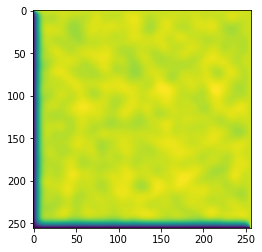

In [ ]:
data = pd.read_csv("./out2",header=None, sep="\t")
T = np.matrix(data)
plt.imshow(T)
plt.show()

#Example for comparison

Am having trouble getting expected speedup, compared my code to 

https://stackoverflow.com/questions/11994679/solving-2d-diffusion-heat-equation-with-cuda?rq=1

figured out 2 things

* Don't forget using doubles in kernels requires architecture level set high enough, though setting too high may overshoot what hardware can handle. 
* I'm having some trouble automatically choosing a good choice of #blocks, #threads per block for best efficiency. Used to just make sure threads per block was a multipe of warp size and never really had much issue with that in the past. Having to hard code more than I like now.



In [ ]:
%%writefile example.cu
/* Blue Waters Petascale Semester Curriculum v1.0
 * Unit 7: CUDA
 * Lesson 9: Heat Diffusion in 1-2 D
 * File: example.cu
 * Developed by David A. Joiner for the Shodor Education Foundation, Inc.
 * Includes code by JackOLantern (https://stackoverflow.com/users/1886641/jackolantern)
 * from https://stackoverflow.com/questions/12004779/optimizing-the-solution-of-the-2d-diffusion-heat-equation-in-cuda/33069555#33069555
 * which is licensed under CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0/)
 *
 * Copyright (c) 2020 The Shodor Education Foundation, Inc.
 *
 * Browse and search the full curriculum at
 * <http://shodor.org/petascale/materials/semester-curriculum>.
 *
 * We welcome your improvements! You can submit your proposed changes to this
 * material and the rest of the curriculum in our GitHub repository at
 * <https://github.com/shodor-education/petascale-semester-curriculum>.
 *
 * We want to hear from you! Please let us know your experiences using this
 * material by sending email to petascale@shodor.org
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU Affero General Public License as published
 * by the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU Affero General Public License for more details.
 *
 * You should have received a copy of the GNU Affero General Public License
 * along with this program.  If not, see <https://www.gnu.org/licenses/>.
 */

#include <iostream>

#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#define BLOCK_SIZE_X 16
#define BLOCK_SIZE_Y 16


#define MIN(a,b) (((a)<(b))?(a):(b))
#define MAX(a,b) (((a)>(b))?(a):(b))

/***********************************/
/* JACOBI ITERATION FUNCTION - GPU */
/***********************************/
__global__ void Jacobi_Iterator_GPU(const float * __restrict__ T_old, float * __restrict__ T_new, const int NX, const int NY)
{
    const int i = blockIdx.x * blockDim.x + threadIdx.x ;
    const int j = blockIdx.y * blockDim.y + threadIdx.y ;

                                //                         N 
    int P = i + j*NX;           // node (i,j)              |
    int N = i + (j+1)*NX;       // node (i,j+1)            |
    int S = i + (j-1)*NX;       // node (i,j-1)     W ---- P ---- E
    int E = (i+1) + j*NX;       // node (i+1,j)            |
    int W = (i-1) + j*NX;       // node (i-1,j)            |
                                //                         S 

    // --- Only update "interior" (not boundary) node points
    if (i>0 && i<NX-1 && j>0 && j<NY-1) T_new[P] = 0.25 * (T_old[E] + T_old[W] + T_old[N] + T_old[S]);
}

/***********************************/
/* JACOBI ITERATION FUNCTION - CPU */
/***********************************/
void Jacobi_Iterator_CPU(float * __restrict T, float * __restrict T_new, const int NX, const int NY, const int MAX_ITER)
{
    for(int iter=0; iter<MAX_ITER; iter=iter+2)
    {
        // --- Only update "interior" (not boundary) node points
        for(int j=1; j<NY-1; j++) 
            for(int i=1; i<NX-1; i++) {
                float T_E = T[(i+1) + NX*j];
                float T_W = T[(i-1) + NX*j];
                float T_N = T[i + NX*(j+1)];
                float T_S = T[i + NX*(j-1)];
                T_new[i+NX*j] = 0.25*(T_E + T_W + T_N + T_S);
            }

        for(int j=1; j<NY-1; j++) 
            for(int i=1; i<NX-1; i++) {
                float T_E = T_new[(i+1) + NX*j];
                float T_W = T_new[(i-1) + NX*j];
                float T_N = T_new[i + NX*(j+1)];
                float T_S = T_new[i + NX*(j-1)];
                T[i+NX*j] = 0.25*(T_E + T_W + T_N + T_S);
            }
    }
}

/******************************/
/* TEMPERATURE INITIALIZATION */
/******************************/
void Initialize(float * __restrict h_T, const int NX, const int NY)
{
    // --- Set left wall to 1
    for(int j=0; j<NY; j++) h_T[j * NX] = 1.0;
}


/********/
/* MAIN */
/********/
int main()
{
    const int NX = 256;         // --- Number of discretization points along the x axis
    const int NY = 256;         // --- Number of discretization points along the y axis

    const int MAX_ITER = 100;     // --- Number of Jacobi iterations

    float *h_T              = (float *)calloc(NX * NY, sizeof(float));
    float *h_T_old          = (float *)calloc(NX * NY, sizeof(float));
    Initialize(h_T,     NX, NY);
    Initialize(h_T_old, NX, NY);
    float *h_T_GPU_result   = (float *)malloc(NX * NY * sizeof(float));

    float *d_T;     cudaMalloc((void**)&d_T,      NX * NY * sizeof(float));
    float *d_T_old; cudaMalloc((void**)&d_T_old,  NX * NY * sizeof(float));
    cudaEvent_t start, stop;
    float milliseconds = 0;
 
   cudaMemcpy(d_T,     h_T, NX * NY * sizeof(float), cudaMemcpyHostToDevice);
   cudaMemcpy(d_T_old, d_T, NX * NY * sizeof(float), cudaMemcpyDeviceToDevice);
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    // --- Grid size
    dim3 dimBlock(BLOCK_SIZE_X, BLOCK_SIZE_Y);
    dim3 dimGrid (MAX(1, NX/BLOCK_SIZE_X), MAX(1,NY/BLOCK_SIZE_Y));

    // --- Jacobi iterations on the host
     cudaEventRecord(start);

    Jacobi_Iterator_CPU(h_T, h_T_old, NX, NY, MAX_ITER);
  cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);
     fprintf(stderr,"Elapsed time in loop (ms) %f\n",milliseconds);

     cudaEventRecord(start);
     cudaEventSynchronize(start);


    // --- Jacobi iterations on the device
    for (int k=0; k<MAX_ITER; k=k+2) {
        Jacobi_Iterator_GPU<<<dimGrid, dimBlock>>>(d_T,     d_T_old, NX, NY);   // --- Update d_T_old     starting from data stored in d_T
        Jacobi_Iterator_GPU<<<dimGrid, dimBlock>>>(d_T_old, d_T    , NX, NY);   // --- Update d_T         starting from data stored in d_T_old
    }
  cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);
     fprintf(stderr,"Elapsed time in loop (ms) %f\n",milliseconds);
 
    // --- Copy result from device to host
    cudaMemcpy(h_T_GPU_result, d_T, NX * NY * sizeof(float), cudaMemcpyDeviceToHost);
  // --- Calculate percentage root mean square error between host and device results
    float sum = 0., sum_ref = 0.;
    for (int j=0; j<NY; j++)
        for (int i=0; i<NX; i++) {
            sum     = sum     + (h_T_GPU_result[j * NX + i] - h_T[j * NX + i]) * (h_T_GPU_result[j * NX + i] - h_T[j * NX + i]);
            sum_ref = sum_ref + h_T[j * NX + i]                                * h_T[j * NX + i];
        }
    printf("Percentage root mean square error = %f\n", 100.*sqrt(sum / sum_ref));

    // --- Release host memory 
    free(h_T);
    free(h_T_GPU_result);

    // --- Release device memory
    (cudaFree(d_T));
    (cudaFree(d_T_old));

    return 0;
}

Writing example.cu


In [ ]:
!nvcc -o example example.cu

In [ ]:
!./example

Elapsed time in loop (ms) 65.977470
Elapsed time in loop (ms) 1.638528
Percentage root mean square error = 0.000000


In [ ]:
%%writefile example_double.cu
#include <iostream>

#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#define BLOCK_SIZE_X 16
#define BLOCK_SIZE_Y 16


#define MIN(a,b) (((a)<(b))?(a):(b))
#define MAX(a,b) (((a)>(b))?(a):(b))

/***********************************/
/* JACOBI ITERATION FUNCTION - GPU */
/***********************************/
__global__ void Jacobi_Iterator_GPU(const double * __restrict__ T_old, double * __restrict__ T_new, const int NX, const int NY)
{
    const int i = blockIdx.x * blockDim.x + threadIdx.x ;
    const int j = blockIdx.y * blockDim.y + threadIdx.y ;

                                //                         N 
    int P = i + j*NX;           // node (i,j)              |
    int N = i + (j+1)*NX;       // node (i,j+1)            |
    int S = i + (j-1)*NX;       // node (i,j-1)     W ---- P ---- E
    int E = (i+1) + j*NX;       // node (i+1,j)            |
    int W = (i-1) + j*NX;       // node (i-1,j)            |
                                //                         S 

    // --- Only update "interior" (not boundary) node points
    if (i>0 && i<NX-1 && j>0 && j<NY-1) T_new[P] = 0.25 * (T_old[E] + T_old[W] + T_old[N] + T_old[S]);
}

/***********************************/
/* JACOBI ITERATION FUNCTION - CPU */
/***********************************/
void Jacobi_Iterator_CPU(double * __restrict T, double * __restrict T_new, const int NX, const int NY, const int MAX_ITER)
{
    for(int iter=0; iter<MAX_ITER; iter=iter+2)
    {
        // --- Only update "interior" (not boundary) node points
        for(int j=1; j<NY-1; j++) 
            for(int i=1; i<NX-1; i++) {
                double T_E = T[(i+1) + NX*j];
                double T_W = T[(i-1) + NX*j];
                double T_N = T[i + NX*(j+1)];
                double T_S = T[i + NX*(j-1)];
                T_new[i+NX*j] = 0.25*(T_E + T_W + T_N + T_S);
            }

        for(int j=1; j<NY-1; j++) 
            for(int i=1; i<NX-1; i++) {
                double T_E = T_new[(i+1) + NX*j];
                double T_W = T_new[(i-1) + NX*j];
                double T_N = T_new[i + NX*(j+1)];
                double T_S = T_new[i + NX*(j-1)];
                T[i+NX*j] = 0.25*(T_E + T_W + T_N + T_S);
            }
    }
}

/******************************/
/* TEMPERATURE INITIALIZATION */
/******************************/
void Initialize(double * __restrict h_T, const int NX, const int NY)
{
    // --- Set left wall to 1
    for(int j=0; j<NY; j++) h_T[j * NX] = 1.0;
}


/********/
/* MAIN */
/********/
int main()
{
    const int NX = 256;         // --- Number of discretization points along the x axis
    const int NY = 256;         // --- Number of discretization points along the y axis

    const int MAX_ITER = 100;     // --- Number of Jacobi iterations

    double *h_T              = (double *)calloc(NX * NY, sizeof(double));
    double *h_T_old          = (double *)calloc(NX * NY, sizeof(double));
    Initialize(h_T,     NX, NY);
    Initialize(h_T_old, NX, NY);
    double *h_T_GPU_result   = (double *)malloc(NX * NY * sizeof(double));

    double *d_T;     cudaMalloc((void**)&d_T,      NX * NY * sizeof(double));
    double *d_T_old; cudaMalloc((void**)&d_T_old,  NX * NY * sizeof(double));
    cudaEvent_t start, stop;
    float milliseconds = 0;
 
   cudaMemcpy(d_T,     h_T, NX * NY * sizeof(double), cudaMemcpyHostToDevice);
   cudaMemcpy(d_T_old, d_T, NX * NY * sizeof(double), cudaMemcpyDeviceToDevice);
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    // --- Grid size
    dim3 dimBlock(BLOCK_SIZE_X, BLOCK_SIZE_Y);
    dim3 dimGrid (MAX(1, NX/BLOCK_SIZE_X), MAX(1,NY/BLOCK_SIZE_Y));

    // --- Jacobi iterations on the host
     cudaEventRecord(start);

    Jacobi_Iterator_CPU(h_T, h_T_old, NX, NY, MAX_ITER);
  cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);
     fprintf(stderr,"Elapsed time in loop (ms) %f\n",milliseconds);

     cudaEventRecord(start);

    // --- Jacobi iterations on the device
    for (int k=0; k<MAX_ITER; k=k+2) {
        Jacobi_Iterator_GPU<<<dimGrid, dimBlock>>>(d_T,     d_T_old, NX, NY);   // --- Update d_T_old     starting from data stored in d_T
        Jacobi_Iterator_GPU<<<dimGrid, dimBlock>>>(d_T_old, d_T    , NX, NY);   // --- Update d_T         starting from data stored in d_T_old
    }
  cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);
     fprintf(stderr,"Elapsed time in loop (ms) %f\n",milliseconds);
 
    // --- Copy result from device to host
    cudaMemcpy(h_T_GPU_result, d_T, NX * NY * sizeof(double), cudaMemcpyDeviceToHost);
  // --- Calculate percentage root mean square error between host and device results
    double sum = 0., sum_ref = 0.;
    for (int j=0; j<NY; j++)
        for (int i=0; i<NX; i++) {
            sum     = sum     + (h_T_GPU_result[j * NX + i] - h_T[j * NX + i]) * (h_T_GPU_result[j * NX + i] - h_T[j * NX + i]);
            sum_ref = sum_ref + h_T[j * NX + i]                                * h_T[j * NX + i];
        }
    printf("Percentage root mean square error = %f\n", 100.*sqrt(sum / sum_ref));

    // --- Release host memory 
    free(h_T);
    free(h_T_GPU_result);

    // --- Release device memory
    (cudaFree(d_T));
    (cudaFree(d_T_old));

    return 0;
}

Overwriting example_double.cu


In [ ]:
!nvcc -o example_double example_double.cu

In [ ]:
!./example_double

Elapsed time in loop (ms) 61.648895
Elapsed time in loop (ms) 1.912832
Percentage root mean square error = 0.000000
